In [ ]:
# default_exp profiling

# Profiling

> some profiling utils I want to keep reusing
> based on [some code I found and enhanced from stackoverflow](https://stackoverflow.com/questions/3620943/measuring-elapsed-time-with-the-time-module)

In [ ]:
#hide
#local
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#hide
#local
from nbdev.showdoc import *

In [ ]:
#exporti
import time
import warnings
from functools import wraps

PROF_DATA = {}

In [ ]:
# #export
# def profile_call(fn):
#     'decorator to profile a method - stores data in PROF_DATA'
#     @wraps(fn)
#     def with_profiling(*args, **kwargs):
#         start_time = time.time()
#         ret = fn(*args, **kwargs)
#         elapsed_time = time.time() - start_time

#         if fn.__name__ not in PROF_DATA:
#             PROF_DATA[fn.__name__] = [0, [],0]
#         PROF_DATA[fn.__name__][0] += 1
#         PROF_DATA[fn.__name__][1].append(elapsed_time)

#         return ret

#     return with_profiling

In [ ]:
#exporti
def _logtime(fn,new_name, args, kwargs):
    # use func name as key if new_name is None else use new_name
    fname = fn.__name__ if new_name is None else new_name
    start_time = time.time()
    ret = fn(*args, **kwargs)
    elapsed_time = time.time() - start_time
    if fname not in PROF_DATA:
        PROF_DATA[fname] = [0, [],0]
    PROF_DATA[fname][0] += 1
    PROF_DATA[fname][1].append(elapsed_time)
    return ret


In [ ]:
#export
def profile_call(decorator_arg, fn_name=None):
    'decorator to profile a method with an optional name - stores data in PROF DATA'
#     print(f'arg is {decorator_arg} type {type(decorator_arg)} fn_name {fn_name}')
    if type(decorator_arg) == str:
        def _inner_profile_call(fn):
            @wraps(fn)
            def with_profiling(*args, **kwargs):
                return _logtime(fn,decorator_arg, args,kwargs)
            return with_profiling
        return _inner_profile_call
    
    # else decorator_arg is function
    fn = decorator_arg
    @wraps(fn)
    def with_profiling(*args, **kwargs):
        return _logtime(fn, fn_name, args, kwargs)

    return with_profiling    

In [ ]:
#exporti
def _print_data(fname, data):
    max_time = max(data[1])
    avg_time = sum(data[1]) / len(data[1])
    print(f'Function {fname} called {data[0]} times.')
    print(f'Execution time max: {max_time:.3f}, average: {avg_time:.3f}')

In [ ]:
#export
def print_prof_data(fname=None):
    'print out profile data'
    if fname is not None:
        if fname not in PROF_DATA:
            warnings.warn(f'Function {fname} has no profile data')
            return
        _print_data(fname, PROF_DATA[fname])
        return
    
    for fname, data in PROF_DATA.items():
        _print_data(fname, data)

In [ ]:
#export
def clear_prof_data():
    'clear out profile data'
    global PROF_DATA
    PROF_DATA = {}

In [ ]:
#export    
def get_prof_data(name):
    'get profile data for name'
    return None if name not in PROF_DATA else PROF_DATA[name][1]

In [ ]:
#export
def start_record(name):
    'start recording time for name'
    start_time = time.time()
    if name not in PROF_DATA:
        PROF_DATA[name] = [0, [],0]
    if PROF_DATA[name][2] != 0:
        warnings.warn(f'function {name} start time not recorded because start time has already been recorded')
        return
    PROF_DATA[name][2] = start_time

In [ ]:
#export
def end_record(name):
    'end recording time and add elapsed time to profile data'
    if name not in PROF_DATA:
        warnings.warn(f'function {name} end time not recorded because start time not found')
        return
    start_time = PROF_DATA[name][2]
    elapsed_time = time.time() - start_time
    PROF_DATA[name][2] = 0
    PROF_DATA[name][0] += 1
    PROF_DATA[name][1].append(elapsed_time)
    

In [ ]:
#export
import pickle
import pathlib

def save_prof_data(file_name, overwrite_file=True):
    'save profile data to `file_name`, `overwrite_file=True` overwrites existing file'
    if not isinstance(file_name, pathlib.Path):
        file_name = pathlib.Path(file_name)
        
    if file_name.is_dir():
        warnings.warn(f'File not saved, {filename} is an existing directory')
        return
    
    if not overwrite_file and file_name.is_file():
        warnings.warn(f'File not saved, {filename} already exists')
        return
    
    with open(file_name,'wb') as f:
        try:
            pickle.dump(PROF_DATA,f)
        except pickle.PickeError as e:
            warnings.warn(f'Error in saving {file_name}, exception triggered {e}')
    f.close()
 

In [ ]:
#export
def load_prof_data(file_name, overwrite_prof_data=True):
    'load profile data from `file_name`, `overwrite_prof_data` overwrites existing profile data'
    if not isinstance(file_name, pathlib.Path):
        file_name = pathlib.Path(file_name)
    if file_name.is_dir():
        warnings.warn(f'File {filename} is a directory, not a file')
        return
    
    if not file_name.is_file():
        warnings.warn(f'File {filename} does not exist')
        return
    
    with open(file_name, 'rb') as f:
        try:
            file_prof_data = pickle.load(f)
        except pickle.PickleError as e:
            warnings.warn(f'Unpickling {file_name} triggered an exception {e}')
            return
        for k,v in file_prof_data.items():
            if k not in PROF_DATA or overwrite_prof_data:
                PROF_DATA[k] = file_prof_data[k]

### Usage Examples

In [ ]:
@profile_call
def test_func(t=2.0):
    time.sleep(1.0)

for i in range(10):
    test_func(i)

print_prof_data()

Function test_func called 10 times.
Execution time max: 1.005, average: 1.002


In [ ]:
times = get_prof_data('test_func'); times

[1.000493049621582,
 1.0050342082977295,
 1.0043659210205078,
 1.0013041496276855,
 1.0002999305725098,
 1.000586986541748,
 1.000143051147461,
 1.0002641677856445,
 1.0027070045471191,
 1.0002517700195312]

In [ ]:
PROF_DATA

{'test_func': [10,
  [1.000493049621582,
   1.0050342082977295,
   1.0043659210205078,
   1.0013041496276855,
   1.0002999305725098,
   1.000586986541748,
   1.000143051147461,
   1.0002641677856445,
   1.0027070045471191,
   1.0002517700195312],
  0]}

In [ ]:
clear_prof_data()

In [ ]:
@profile_call('wachacha')
def test_func2(t=1.0):
    time.sleep(t)

In [ ]:
for i in range(10):
    test_func2()
    
print_prof_data()

Function wachacha called 10 times.
Execution time max: 1.004, average: 1.001


In [ ]:
clear_prof_data()

In [ ]:
@profile_call
def test_func3(t=1.0):
    time.sleep(1.0)

In [ ]:
for i in range(10):
    test_func3()
    
print_prof_data()

Function test_func3 called 10 times.
Execution time max: 1.005, average: 1.002


In [ ]:
for i in range(10):
    start_record('timed_sleep')
    time.sleep(i)
    end_record('timed_sleep')

In [ ]:
print_prof_data('timed_sleep')
times2 = get_prof_data('timed_sleep')

Function timed_sleep called 10 times.
Execution time max: 9.002, average: 4.501


As an alternative, the decorator can be invoked this way

In [ ]:
sleep = profile_call(time.sleep)

In [ ]:
for i in range(5):
    sleep(i)

print_prof_data()

Function test_func3 called 10 times.
Execution time max: 1.005, average: 1.002
Function timed_sleep called 10 times.
Execution time max: 9.002, average: 4.501
Function sleep called 5 times.
Execution time max: 4.001, average: 2.002


In [ ]:
clear_prof_data()

In [ ]:
sleep = profile_call(time.sleep,'malumam')

In [ ]:
for i in range(5):
    sleep(1)

print_prof_data()

Function malumam called 5 times.
Execution time max: 1.003, average: 1.001


In [ ]:
#local
import pathlib

In [ ]:
save_file = 'my_profile_data.pickle'

In [ ]:
#local
if pathlib.Path(save_file).is_file(): pathlib.Path(save_file).unlink()

In [ ]:
save_prof_data(save_file)

Assert that `my_profile_data.pickle` file was created.

In [ ]:
#local
assert pathlib.Path(save_file).is_file()

In [ ]:
clear_prof_data()

In [ ]:
print_prof_data()

In [ ]:
PROF_DATA

{}

In [ ]:
load_prof_data(save_file)

In [ ]:
print_prof_data()

Function malumam called 5 times.
Execution time max: 1.003, average: 1.001


In [ ]:
#local
pathlib.Path(save_file).unlink()

In [ ]:
#local
import matplotlib.pyplot as plt

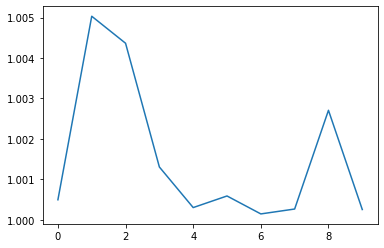

In [ ]:
#local
plt.plot(times);

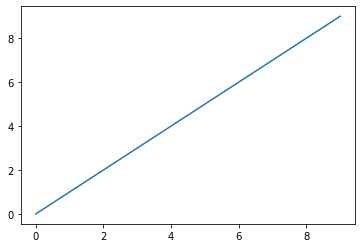

In [ ]:
#local
plt.plot(times2);